## Task 3 / Homework

In this task, we will compare the performance of the different models we have trained so far. We will compare the performance of the CNN (Convolutional Neural Networks) and MLP (Multi-Layer Perceptron) models. We will also compare the performance of the models after permuting the pixels of the images. We will use the MNIST dataset for this task.

In [31]:
## Imports the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [32]:
## Functions to plot the data and the output of the model
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

In [33]:
set_default()

In [34]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [36]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)


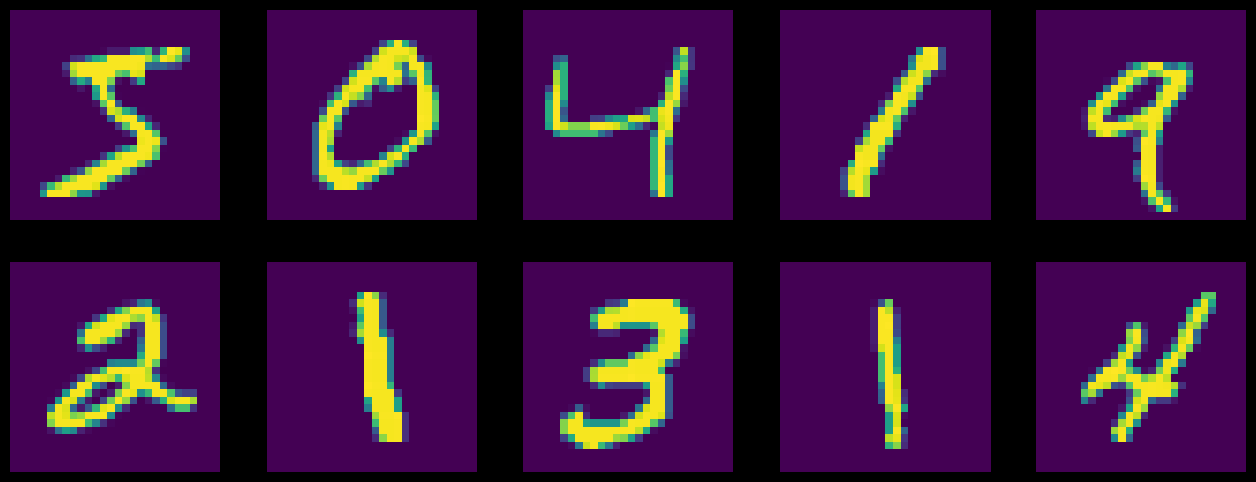

In [37]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [38]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)


## Train and test a given model

In [39]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [40]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325415
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.853103
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.250767
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.829705
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.636147
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.551720
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.411274
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.319498
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.442876
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.340181

Test set: Average loss: 0.4040, Accuracy: 8816/10000 (88%)



# Train a ConvNet with the same number of parameters

In [41]:
# Definition of a ConvNet
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [42]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.357405
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.965288
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.307231
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.549771
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.512305
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.191424
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.275063
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.244729
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.148306
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.081480

Test set: Average loss: 0.1499, Accuracy: 9528/10000 (95%)



## ***Question: Why the accuracy of the CNN is higher than the MLP accuracy? The two neural networks have the same number of parameters, why we observe such a difference in the results?***

The higher accuracy of the CNN model is attributed to its ability to efficiently extract and process spatial features from the image, a capability that is inherently lacking in the FC2 (MLP) model due to its fully connected architecture. This makes the CNN particularly well-suited for image classification tasks like MNIST, even when the number of parameters is similar to that of an MLP.

In the MLP Model architecture the input data is flattened before being fed into the network. Each parameter is used independently and does not share information across different parts of the image. The model treats the input image as a flat vector, losing spatial relationships between pixels. The major limitation here is the lack of spatial feature extraction. The model does not inherently capture the local patterns (like edges, corners) which are crucial for image data.

Convolutional layers in the CNN Model archetecture are adept at capturing local patterns in the image (like edges, textures) and maintaining the spatial hierarchy of features. That is because the same filter (set of weights) is applied across different parts of the input image. Max pooling also reduces the spatial dimension of the feature maps, helping the network to focus on the most important features. This as well provides some level of translational invariance.

Therefore feature extraction is way better in CNN. Even though MLP is flexible, it is not as efficient for image data because it does not maintain the spatial relationships between pixels.

# Use the following code to create a random permutation of the pixels in each image

In [43]:
perm = torch.randperm(784)

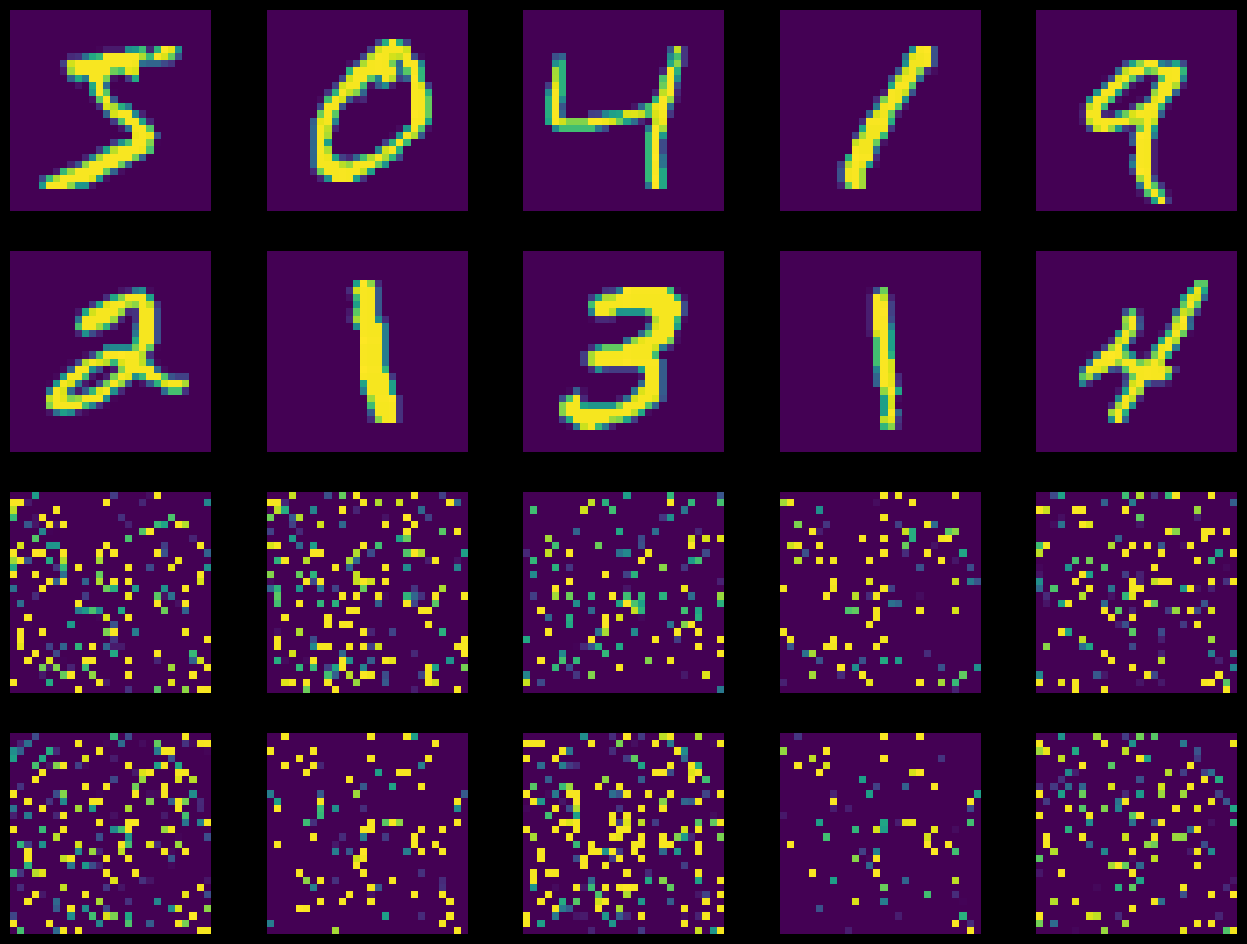

In [44]:
# visualize some permuted images
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [45]:
def rand_perm(image):
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    return image_perm

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       rand_perm
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       rand_perm
                   ])),
    batch_size=1000, shuffle=True)

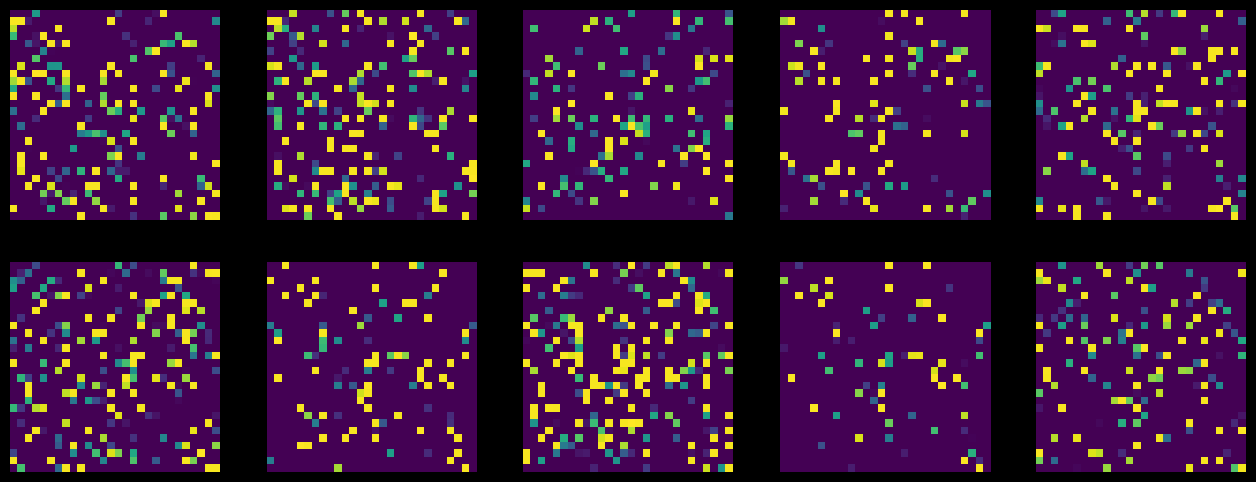

In [46]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Train a small fully-connected network

In [47]:
# Write your code here
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312543
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.777749
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.110822
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.073103
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.799166
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.727756
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.580501
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.414571
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.656523
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.403655

Test set: Average loss: 0.4566, Accuracy: 8644/10000 (86%)



# Train a ConvNet with the same number of parameters

In [48]:
# Write your code here
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301723
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.297014
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.250241
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.057503
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.707279
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.126123
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.996659
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.618523
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.813487
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.510170

Test set: Average loss: 0.5701, Accuracy: 8219/10000 (82%)



## ***Question: In the perturbed dataset we can observe different results, now is the CNN model to be less accurate then the MLP model, why is this the case?***

MLPs treat the input image as a flattened vector of pixels. This means that they do not rely on the spatial relationships between pixels. As a result, permuting the pixels of the images doesn't fundamentally change how the MLP processes the data. Each parameter independently contributes to the final classification without considering the spatial structure. This independence from the spatial arrangement makes the MLP's performance almost not affected at all by the pixel permutation.

CNNs are highly effective at recognizing spatial hierarchies and local patterns in images as mentioned before. When the pixels are permuted, these spatial relationships are disrupted. The convolutional layers in the CNN, which are designed to detect local features like edges, corners, and textures, are less effective because these features are no longer consistently present in the same spatial arrangement. Therefore, when the image is perturbed, the translationally invariant features become meaningless for the pooling layers, as the inherent structure of the image is altered. The permutation of the image pixels significantly impact its ability to correctly classify the images, as the learned filters become ineffective in the perturbed context.

in clonclusion, the MLP doesn’t extract spatial features but rather learns a mapping based on the presence or absence of certain pixel values, regardless of their position. The CNN, however, tries to map spatial features to outputs, and when these features are distorted, its performance degrades. This is CNN bacomes less accurate in this case.



## Homework: As homework we require you to try different at least 10 different seed per model and report the average accuracy and standard deviation for the MLP and CNN models in the normal dataset and in the perturbed dataset. Again we require you to discuss this results as we did in class and write a short paragraph with your conclusions.

## Normal data set



In [49]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

### MLP

In [50]:
n_hidden = 8  # number of hidden units
num_seeds = 10
average_accuracies = []

for seed in range(num_seeds):
    torch.manual_seed(seed)

    model_fnn = FC2Layer(input_size, n_hidden, output_size)
    model_fnn.to(device)
    optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(0, 1):
        train(epoch, model_fnn)
        test(model_fnn)

    # Calculate average accuracy for this seed
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    average_accuracies.append(average_accuracy)
    accuracy_list.clear()  # Clear list for the next seed

# Calculate overall average accuracy across all seeds
overall_average_accuracy = sum(average_accuracies) / num_seeds
print("Average accuracy over {} seeds for MLP: {:.2f}%".format(num_seeds, overall_average_accuracy))

std_deviation = np.std(average_accuracies)
print("Standard Deviation: {:.2f}".format(std_deviation))



Train Epoch: 0 [0/60000 (0%)]	Loss: 2.357070
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.756189
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.919053
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.817046
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.872751
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.294905
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.505917
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.513776
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.366381
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.577426

Test set: Average loss: 0.3755, Accuracy: 8902/10000 (89%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.375799
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.949391
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.377854
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.908075
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.768946
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.548026
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.529956
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.501254
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.417933
T

### CNN

In [51]:

n_features = 6  # number of feature maps in the CNN
num_seeds = 10
average_accuracies = []

for seed in range(num_seeds):
    torch.manual_seed(seed)

    model_cnn = CNN(input_size, n_features, output_size)
    model_cnn.to(device)
    optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(0, 1):
        train(epoch, model_cnn)
        test(model_cnn)

    # Calculate average accuracy for this seed
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    average_accuracies.append(average_accuracy)
    accuracy_list.clear()  # Clear list for the next seed

# Calculate overall average accuracy across all seeds
overall_average_accuracy = sum(average_accuracies) / num_seeds
print("Average accuracy over {} seeds for CNN: {:.2f}%".format(num_seeds, overall_average_accuracy))

std_deviation = np.std(average_accuracies)
print("Standard Deviation: {:.2f}".format(std_deviation))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294565
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.869223
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.559171
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.325441
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.160698
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.224434
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.149942
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.385930
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.194056
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.198474

Test set: Average loss: 0.1435, Accuracy: 9547/10000 (95%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290798
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.343889
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.365929
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.506080
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.498915
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.466192
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.332887
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.286515
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.415384
T

## Permuted data set

In [52]:
perm = torch.randperm(784)
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       rand_perm
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       rand_perm
                   ])),
    batch_size=1000, shuffle=True)

### MLP

In [53]:
n_hidden = 8  # number of hidden units
num_seeds = 10
average_accuracies = []

for seed in range(num_seeds):
    torch.manual_seed(seed)

    model_fnn = FC2Layer(input_size, n_hidden, output_size)
    model_fnn.to(device)
    optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(0, 1):
        train(epoch, model_fnn)
        test(model_fnn)

    # Calculate average accuracy for this seed
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    average_accuracies.append(average_accuracy)
    accuracy_list.clear()  # Clear list for the next seed

# Calculate overall average accuracy across all seeds
overall_average_accuracy = sum(average_accuracies) / num_seeds
print("Average accuracy over {} seeds for MLP: {:.2f}%".format(num_seeds, overall_average_accuracy))

std_deviation = np.std(average_accuracies)
print("Standard Deviation: {:.2f}".format(std_deviation))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.378345
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.795157
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.828994
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.741534
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.801199
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.227877
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.508062
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.546143
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.379495
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.526519

Test set: Average loss: 0.3921, Accuracy: 8795/10000 (88%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.370643
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.987881
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.350757
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.975416
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.715236
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.607010
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.579176
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.541457
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.473269
T

### CNN

In [55]:
n_features = 6  # number of feature maps in the CNN
num_seeds = 10
average_accuracies = []

for seed in range(num_seeds):
    torch.manual_seed(seed)

    model_cnn = CNN(input_size, n_features, output_size)
    model_cnn.to(device)
    optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(0, 1):
        train(epoch, model_cnn)
        test(model_cnn)

    # Calculate average accuracy for this seed
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    average_accuracies.append(average_accuracy)
    accuracy_list.clear()  # Clear list for the next seed

# Calculate overall average accuracy across all seeds
overall_average_accuracy = sum(average_accuracies) / num_seeds
print("Average accuracy over {} seeds for CNN: {:.2f}%".format(num_seeds, overall_average_accuracy))

std_deviation = np.std(average_accuracies)
print("Standard Deviation: {:.2f}".format(std_deviation))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298836
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.236490
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.241208
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.022960
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.513407
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.176025
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.837960
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.775419
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.572852
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.560088

Test set: Average loss: 0.6128, Accuracy: 8027/10000 (80%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.281918
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.263066
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.186389
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.884329
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.416199
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.996300
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.875429
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.931001
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.930907
T

The results from the normal dataset align with standard expectations for MLP and CNN models. The CNN significantly outperforms the MLP in average accuracy (94.84% vs. 86.34%), showcasing its strength in handling structured image data, where spatial relationships are key. The lower standard deviation in CNN (0.44) compared to MLP (1.75) also indicates that CNN's performance is more consistent across different initializations.

In contrast, the perturbed dataset presents a different picture. While the MLP's accuracy remains relatively stable (86.90%), with a slight decrease in standard deviation (1.20), indicating robustness to pixel permutation, the CNN shows a notable decline in performance (average accuracy dropping to 80.31%) and a significant increase in variability (standard deviation rising to 3.15). This suggests that the CNN's ability to recognize patterns is heavily disrupted by the perturbation of pixel positions, impacting both its accuracy and consistency.

The results demonstrate that while CNNs are generally more effective and consistent for image classification tasks with structured data, their performance can significantly degrade when the spatial integrity of the data is compromised. Conversely, MLPs, while less accurate in structured scenarios, display more resilience to changes in the spatial arrangement of data, as evidenced by their stable performance on the perturbed dataset. This highlights the importance of considering the nature of the data and the task when choosing between MLP and CNN models.